In [1]:
import numpy as np
from matplotlib import pyplot as plt
import meshio
import tetgen
from Mesh_tetra import Mesh
import pyvista as pv
from scipy.linalg import eigh
from jax import vmap

Se importa la malla con hexahedros y se escribe en vtu para poder obtener tetraedros.

In [2]:
nodes = np.genfromtxt('S8/S8.node', skip_header=True)
connectivity = np.genfromtxt('S8/S8.ele', skip_header=True).astype(int)
def_mapping = np.genfromtxt('S8/S8.DENSE')
def_mapping = def_mapping.reshape((-1,3,def_mapping.shape[-1]))
mesh = meshio.Mesh(nodes, {'hexahedron':connectivity})
mesh.write('S8.vtu')

Se guardan los puntos de def_mapping (desplazamiento) para cada tiempo para visualizar en Paraview.

In [3]:
for i in range(def_mapping.shape[-1]):
    np.savetxt('DENSEpoints/points_%i.csv' % i, def_mapping[:,:,i])

Para realizar la transformación de hexaedros a tetraedros, se utiliza la malla volumétrica hexaédrica $S1.vtu$ en Paraview y se realiza lo siguiente:
* Extract Surface
* Triangulate

No es necesario aplicar triangulate, ya que al usar pyvista, este lo hace por sí sólo, pero yo decidí triangularlo antes. Por otro lado, no sirve el filtro Tetrahedralize porque para usar pyvista y obtener la connectividad correctamente, se necesita la malla con superficie triangular. Una vez exportada a Paraview, se trinagulariza y con pyvista se obtendrán tetraedros.

### OJO
Para todo, se utiliza la versión 5.11.2 de Paraview.

In [4]:
# The heart surface is generated with Paraview, exported in .stl and then the tetrahedra are generated with tetgen
# Information respect tetrahedralize found in https://tetgen.pyvista.org/api.html
data_dense = pv.PolyData('S8_triangles.stl')

tet = tetgen.TetGen(data_dense)
tet.make_manifold()
tet.tetrahedralize(minratio = 1.0, mindihedral = 30)

heart_grid = tet.grid

# create Mesh object
connectivity_dense = heart_grid.cells_dict[10] # extract tetrahedra
points_dense       = heart_grid.points

m = Mesh(verts = points_dense, connectivity = connectivity_dense)
m.writeVTU(filename = "S8_tetra.vtu")

print('Computing Laplacian')
K, M = m.computeLaplacian()

print('Computing eigen values')
eigvals, eigvecs = eigh(K,M)

Computing Laplacian
Computing eigen values


In [6]:
m.writeVTU(filename = "Dense3D_eigfuncs.vtu", scalars = {'v1': eigvecs[:,1], 'v10': eigvecs[:,10], 'v50': eigvecs[:,50], 'v60': eigvecs[:,60], 'v75': eigvecs[:,75], 'v100': eigvecs[:,100], 'v150': eigvecs[:,150], 'v200': eigvecs[:,200], 'v250': eigvecs[:,250], 'v300': eigvecs[:,300]})

Se grafican los puntos obtenidos

c:\Users\Rodrigo\anaconda3\envs\jaxgpu\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\Rodrigo\anaconda3\envs\jaxgpu\lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


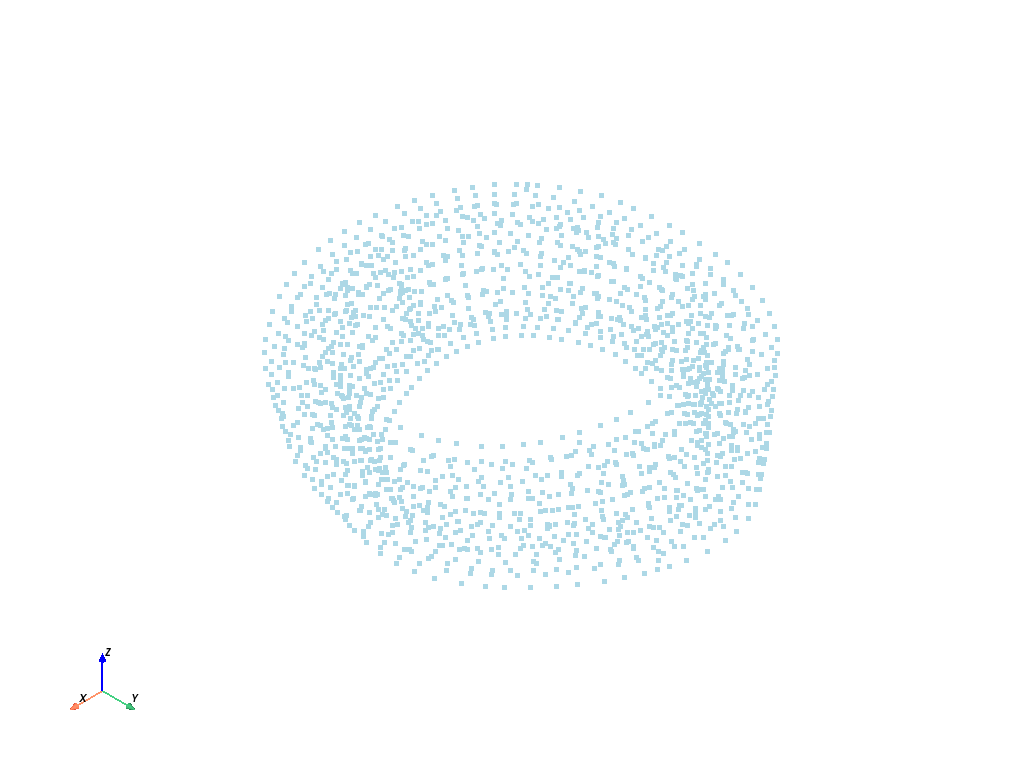

In [7]:
mesh_mid_points = pv.PolyData(points_dense)
mesh_mid_points.plot('data')

c:\Users\Rodrigo\anaconda3\envs\jaxgpu\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\Rodrigo\anaconda3\envs\jaxgpu\lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


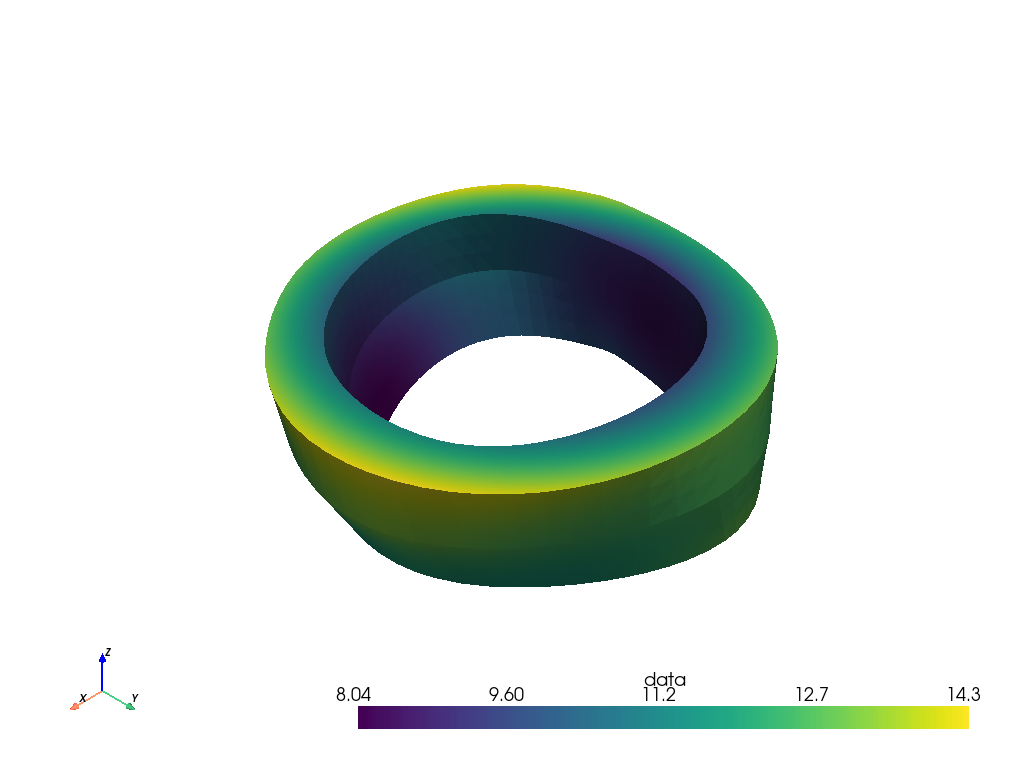

In [8]:
new_mesh = pv.UnstructuredGrid({pv.CellType.TETRA:connectivity_dense}, points_dense)
new_mesh['data'] = points_dense
new_mesh.plot('data')

Ahora, se revisa qué puntos caen dentro de la malla, puesto que se deben remover para poder realizar el procesamiento correcto, si no, arrojaría errores.

c:\Users\Rodrigo\anaconda3\envs\jaxgpu\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\Rodrigo\anaconda3\envs\jaxgpu\lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


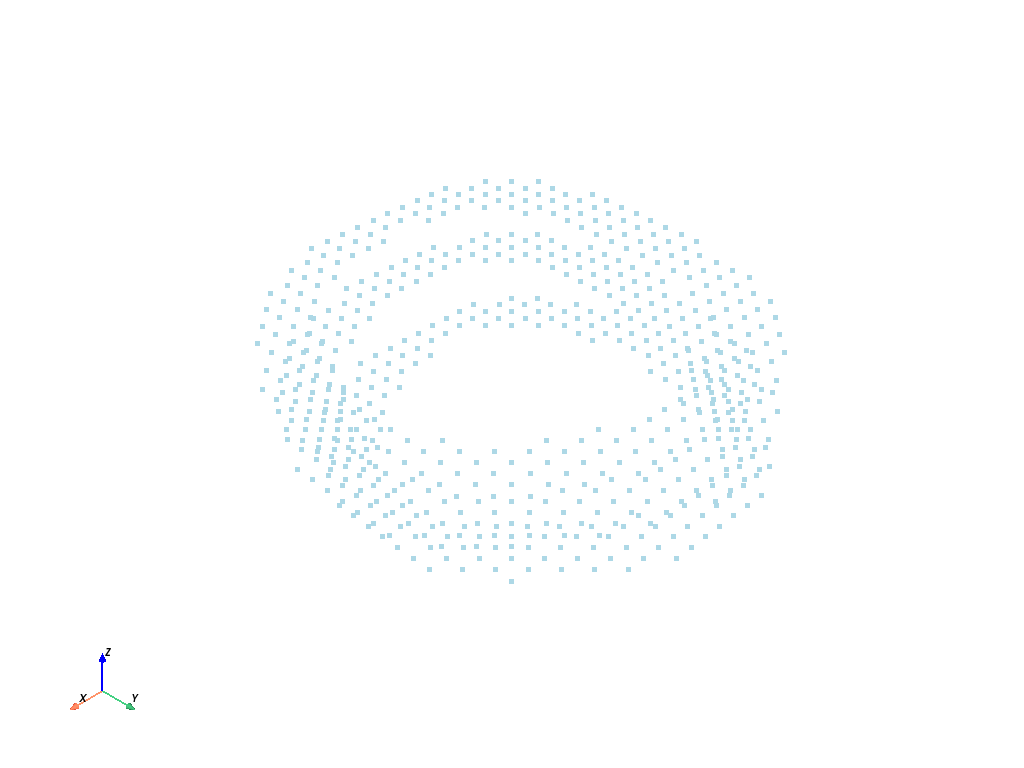

In [9]:
new_points = def_mapping[:,:,0] # time zero
mesh_points = pv.PolyData(new_points)
result = mesh_points.sample(new_mesh)
mesh_points.plot('data')

c:\Users\Rodrigo\anaconda3\envs\jaxgpu\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\Rodrigo\anaconda3\envs\jaxgpu\lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


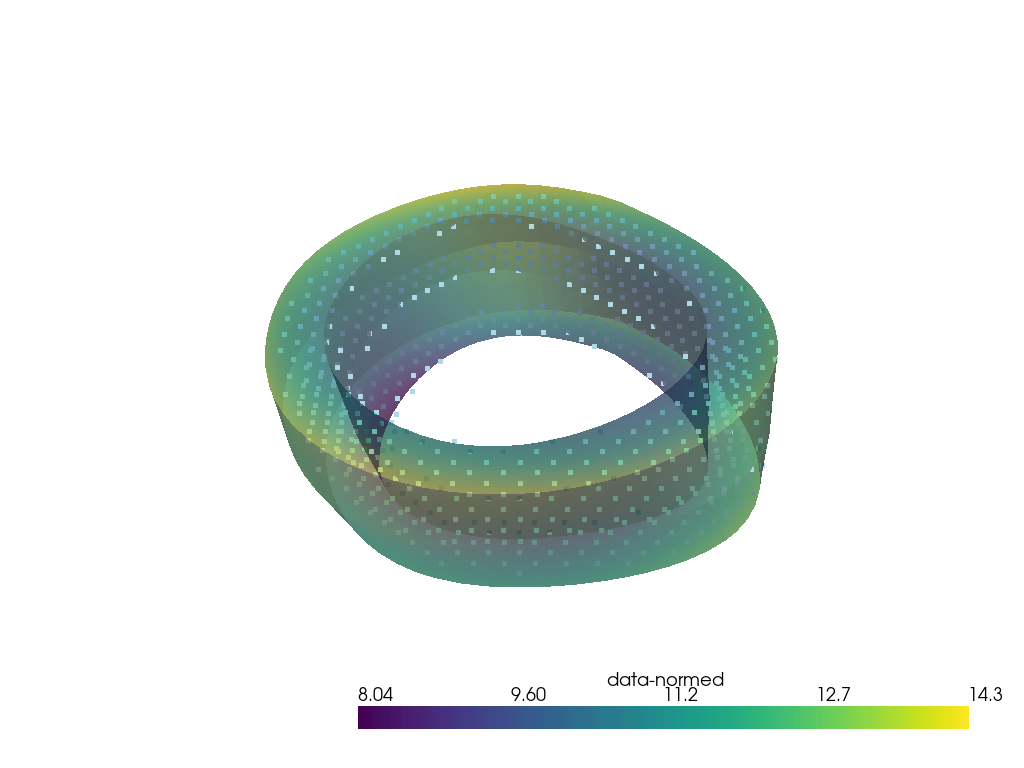

In [10]:
pl = pv.Plotter()
pl.add_mesh(new_mesh, opacity=0.5)
pl.add_mesh(mesh_points)
pl.show()

c:\Users\Rodrigo\anaconda3\envs\jaxgpu\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\Rodrigo\anaconda3\envs\jaxgpu\lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


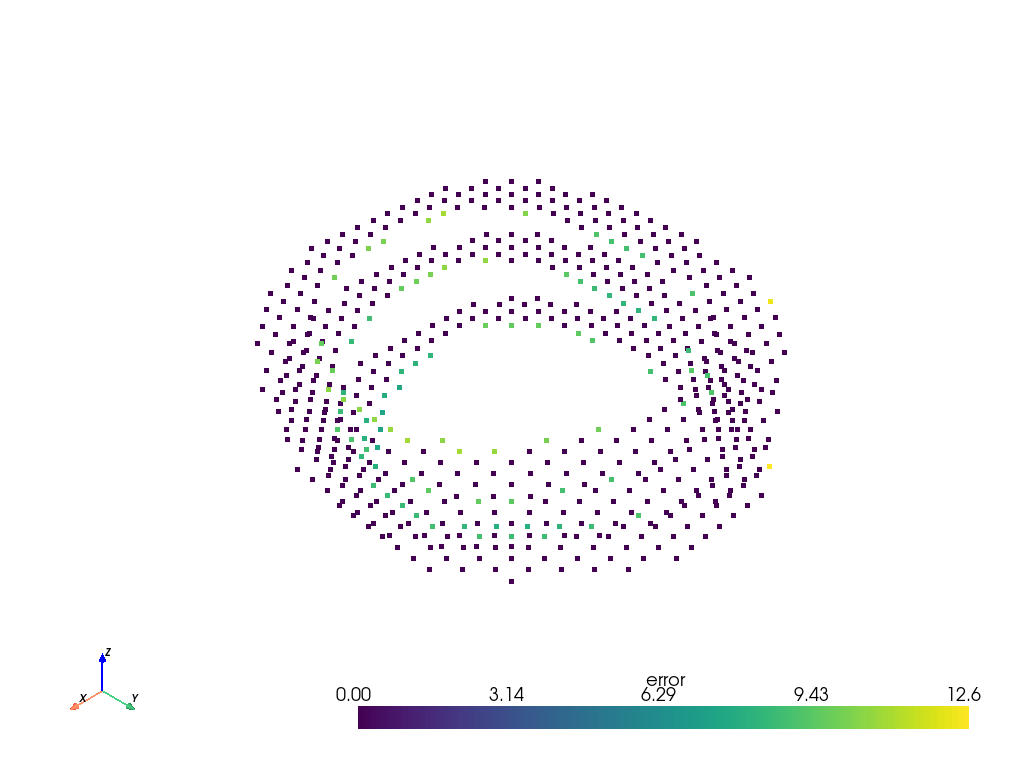

In [11]:
mesh_points['error'] = np.linalg.norm(result['data'] - def_mapping[:,:,0], axis = 1)
mesh_points.plot()

In [12]:
error = np.linalg.norm(result['data'] - def_mapping[:,:,0], axis = 1)
tol = 1e-6

index_effective_points = np.squeeze(np.argwhere(error < tol))
effective_points = new_points[index_effective_points]

print("El número de puntos que caen fuera es:", def_mapping.shape[0] - effective_points.shape[0])

El número de puntos que caen fuera es: 90


c:\Users\Rodrigo\anaconda3\envs\jaxgpu\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\Rodrigo\anaconda3\envs\jaxgpu\lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


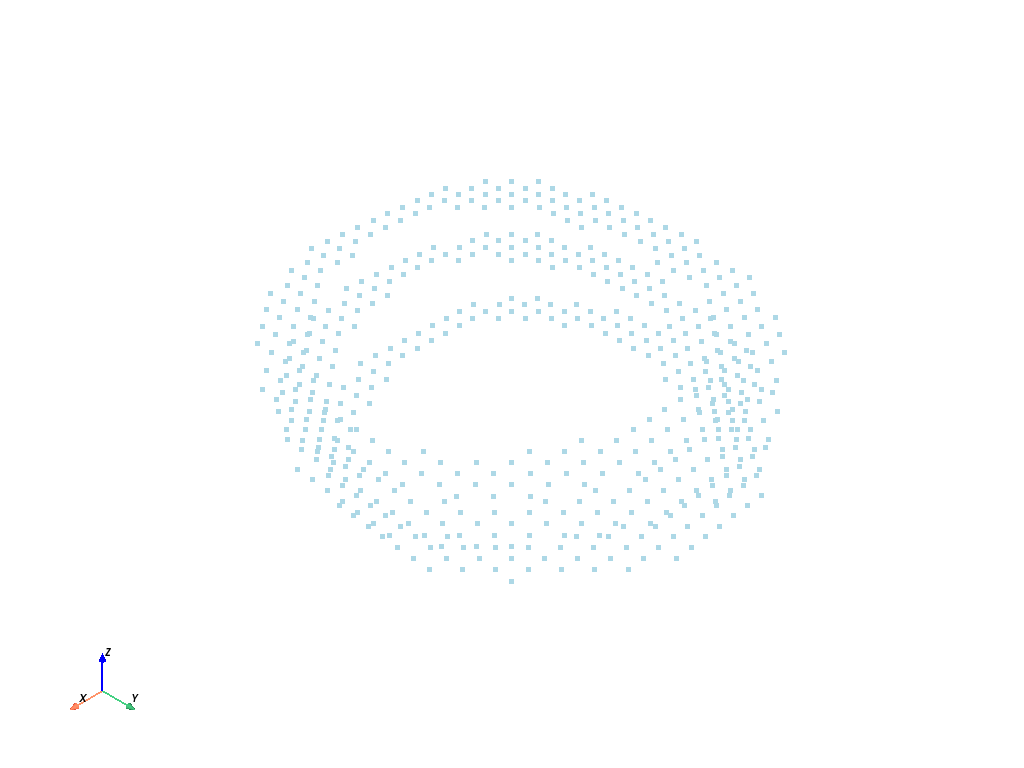

In [13]:
mesh_points = pv.PolyData(effective_points)
result = mesh_points.sample(new_mesh)
mesh_points.plot('data')

c:\Users\Rodrigo\anaconda3\envs\jaxgpu\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\Rodrigo\anaconda3\envs\jaxgpu\lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


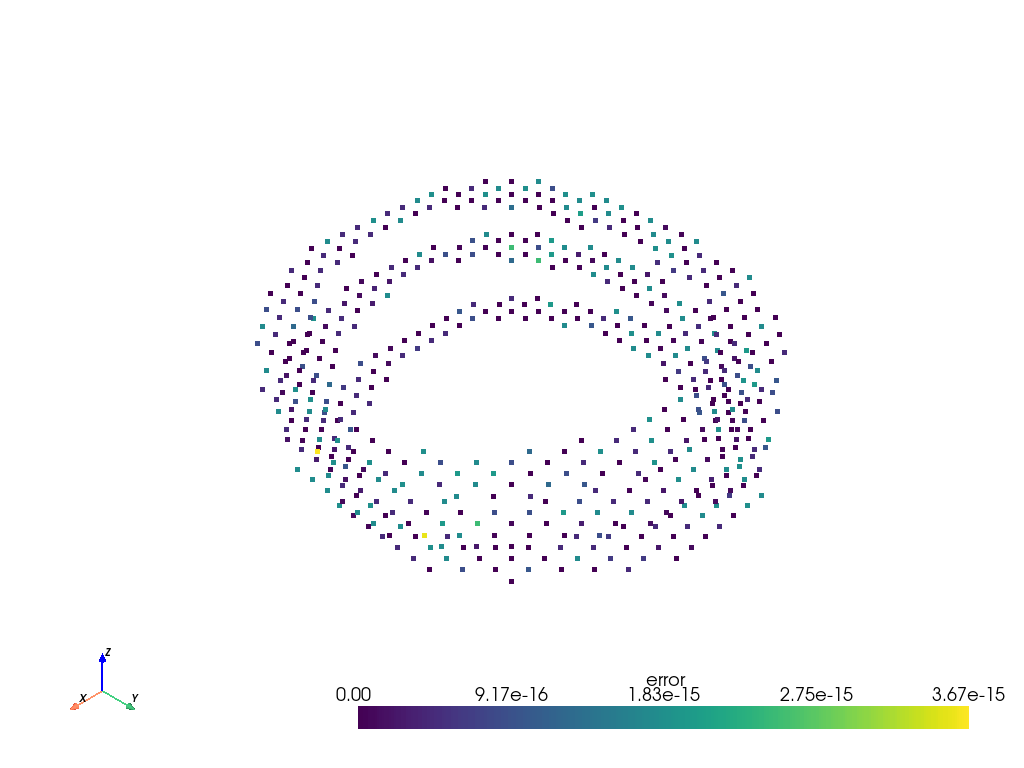

In [14]:
mesh_points['error'] = np.linalg.norm(result['data'] - effective_points, axis = 1)
mesh_points.plot()

In [15]:
error = np.linalg.norm(result['data'] - effective_points, axis = 1)
print(error.max())

3.6687789788066426e-15


In [16]:
ind = []
for i in range(error.shape[0]):
    if error[i] > tol:
        ind.append(i)
ind = np.array(ind)

print(ind.shape)

(0,)
